In [138]:
import pandas as pd
from pymongo import MongoClient
import json
import sys
import seaborn as sns
from os import path, mkdir
from matplotlib import pyplot as plt
import geopandas as gpd
import contextily as ctx
import requests


In [139]:
def db_to_csv():
    with open(sys.path[0] + "/config.json") as config:
        conf_json = json.load(config)
        connection_string = conf_json["connection_string"]
        client = MongoClient(connection_string)

    DB = client["UPA"]
    patients_coll = DB["patients"]
    medical_coll = DB["medical_facilities"]

    patients_df = pd.DataFrame(list(patients_coll.find()))
    facilities_df = pd.DataFrame(list(medical_coll.find()))

    patients_df.to_csv('patients_mongo.csv', sep=';', encoding='utf-8')
    facilities_df.to_csv('facilities_mongo.csv', sep=';',
                         encoding='windows-1250')

    return patients_df, facilities_df


In [140]:
if not path.isfile('patients_mongo.csv') or not path.isfile('facilities_mongo.csv'):
    db_to_csv()
if not path.isdir('plots'):
        mkdir('plots')

In [141]:
patients_df = pd.read_csv('patients_mongo.csv', delimiter=';')
patients_df['casref_do'] = pd.to_datetime(patients_df['casref_do'])
facilities_df = pd.read_csv('facilities_mongo.csv',
                            encoding='windows-1250', delimiter=';')


### Dotaz A:
#### Vytvořte sloupcové grafy zobrazující počty poskytovatelů určitého oboru pro Brno a zbytek Jihomoravského kraje. Pro zobrazení libovolně vyberte 15 typů poskytovatelů.

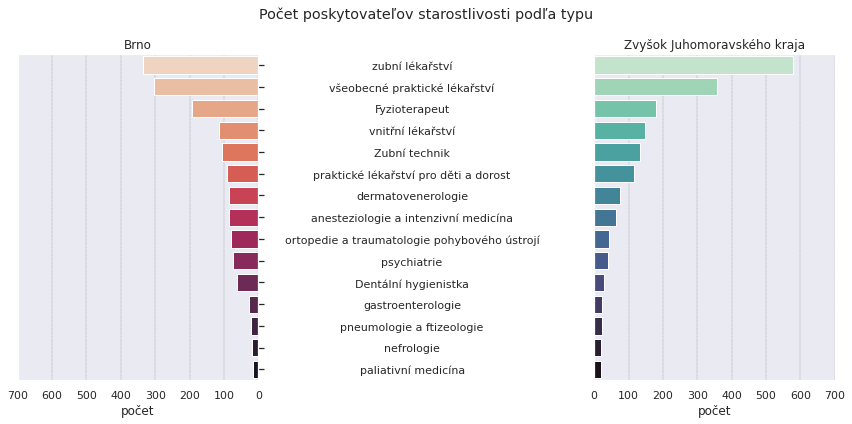

In [142]:
def plot_facilities_types(facilities_df):
    # BRNO PLOT
    fig, axes = plt.subplots(1, 2, sharex=False, figsize=(12, 6))
    fig.suptitle('Počet poskytovateľov starostlivosti podľa typu')
    brno_df = facilities_df[facilities_df["Obec"] == "Brno"].copy()
    types = ["všeobecné praktické lékařství", "Fyzioterapeut", "pneumologie a ftizeologie",
             "psychiatrie", "Dentální hygienistka", "nefrologie",
             "zubní lékařství", "vnitřní lékařství", "anesteziologie a intenzivní medicína",
             "paliativní medicína", "dermatovenerologie", "gastroenterologie",
             "praktické lékařství pro děti a dorost", "Zubní technik", "ortopedie a traumatologie pohybového ústrojí"]
    brno_df = brno_df[brno_df['OborPece'].isin(types)]
    sns.countplot(ax=axes[0], data=brno_df, y='OborPece', orient='h',
                  palette='rocket_r', order=brno_df['OborPece'].value_counts().index)
    axes[0].set_xlabel('počet')
    axes[0].set_ylabel('')
    axes[0].set_title('Brno')
    axes[0].yaxis.set_label_position("right")
    axes[0].yaxis.tick_right()
    axes[0].invert_xaxis()
    axes[0].set_yticklabels(axes[0].get_yticklabels(),
                            ha='center', position=(1.6, 0))

    # JHM PLOT
    jhm_df = facilities_df[facilities_df["Kraj"] == "Jihomoravský kraj"].copy()
    jhm_df = jhm_df[jhm_df["Obec"] != "Brno"]
    jhm_df = jhm_df[jhm_df['OborPece'].isin(types)]
    sns.countplot(ax=axes[1], data=jhm_df, y='OborPece', orient='h',
                  palette='mako_r', order=jhm_df['OborPece'].value_counts().index)
    axes[1].set_xlabel('počet')
    axes[1].set_ylabel('')
    axes[1].set_title('Zvyšok Juhomoravského kraja')
    axes[1].set(yticklabels=[])

    axes[0].set_xticks(axes[1].get_xticks())
    axes[1].set_xticks(axes[1].get_xticks())
    axes[0].xaxis.grid(linestyle=':', linewidth=0.3, color='black')
    axes[0].set_axisbelow(True)
    axes[1].xaxis.grid(linestyle=':', linewidth=0.3, color='black')
    axes[1].set_axisbelow(True)

    plt.tight_layout()
    plt.savefig('plots/poskytovatelia_brno.png')


plot_facilities_types(facilities_df)


### Dotaz A:
#### Vytvořte čárový (spojnicový) graf zobrazující historii počtu poskytovatelů v 5 zvolených oborech. Vyberte obory, u kterých lze očekávat výraznější změny v počtu poskytovatelů (např. dentální hygienistka). Nemusíte zobrazovat data pro každý měsíc, stačí čtvrtletní hodnoty.

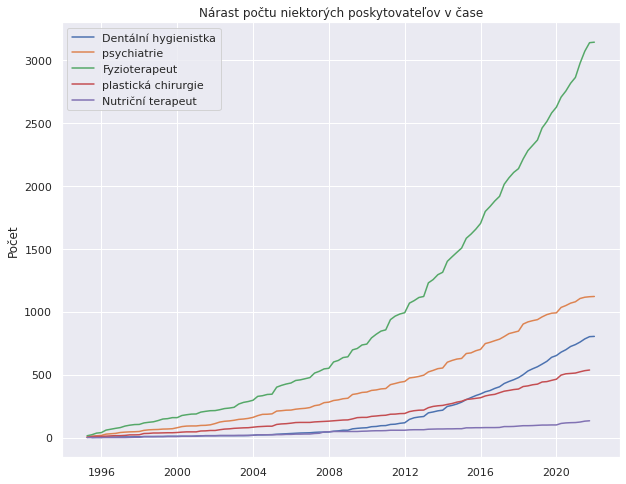

In [143]:
def plot_history_count(facilities_df):
    history_df = facilities_df.copy()
    history_df['DatumZahajeniCinnosti'] = pd.to_datetime(
        history_df['DatumZahajeniCinnosti'])
    history_df = history_df[history_df['DatumZahajeniCinnosti'] > pd.Timestamp(
        1995, 1, 1)]

    dgs = []
    types = ["Dentální hygienistka", "psychiatrie",
             "Fyzioterapeut", "plastická chirurgie", "Nutriční terapeut"]
    fig = plt.figure(figsize=(10,8))
    ax = fig.gca()
    for index, obor in enumerate(types):
        tmp_df = history_df[history_df['OborPece'] == obor]
        dgs.append(tmp_df.groupby(pd.Grouper(
            key='DatumZahajeniCinnosti', freq='1Q')).count())
        dgs[index]['cumSum'] = dgs[index]['OborPece'].cumsum()
        sns.lineplot(data=dgs[index], x=dgs[index].index, y='cumSum', ax=ax)
    plt.legend(types)
    plt.xlabel('')
    plt.ylabel('Počet')
    plt.title('Nárast počtu niektorých poskytovateľov v čase')
    plt.savefig('plots/casovy_rast.png')


plot_history_count(facilities_df)


#### Vlastný graf: Pomer počtu mužov a žien vo veku 20 až 25 rokov. 

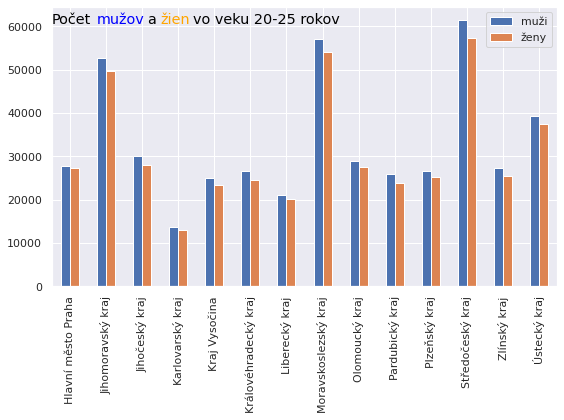

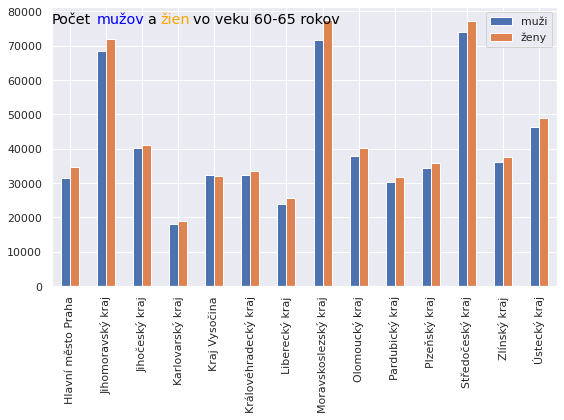

In [144]:
def plot_gender_stats(patients_df):
    df = patients_df.copy()
    df_2020 = df[df['casref_do'] > pd.Timestamp(2020, 12, 30)]
    df_2020 = df_2020[df_2020['vek_txt'] ==
                      '20 až 25 (více nebo rovno 20 a méně než 25)']
    df_2020 = df_2020[df_2020['Kraj'] != 'Česká republika']

    df_2020_m = df_2020[df_2020['pohlavi_kod'] == 1].groupby('Kraj').sum()
    df_2020_f = df_2020[df_2020['pohlavi_kod'] == 2].groupby('Kraj').sum()

    df_2020_m['ženy'] = df_2020_f['hodnota']
    df_2020_m = df_2020_m.rename(columns={'hodnota': 'muži'})

    bar1 = df_2020_m.plot(kind='bar', y=['muži', 'ženy'], figsize=(8, 6))
    bar1.set_xlabel('')
    bar1.set_ylabel('')
    plt.figtext(0.22, 0.93, "mužov", fontsize='large',
                color='blue', ha='center')
    plt.figtext(0.34, 0.93, "žien", fontsize='large',
                color='orange', ha='right')
    plt.figtext(0.1, 0.93, 'Počet', fontsize='large', color='black', ha='left')
    plt.figtext(0.599, 0.93, 'vo veku 20-25 rokov',
                fontsize='large', color='black', ha='right')
    plt.figtext(0.28, 0.93, 'a', fontsize='large', color='black', ha='right')
    plt.tight_layout()
    plt.savefig('plots/sex_diff1.png')


    df = patients_df.copy()
    df_2020 = df[df['casref_do'] > pd.Timestamp(2020, 12, 30)]
    df_2020 = df_2020[df_2020['vek_txt'] ==
                      '60 až 65 (více nebo rovno 60 a méně než 65)']
    df_2020 = df_2020[df_2020['Kraj'] != 'Česká republika']

    df_2020_m = df_2020[df_2020['pohlavi_kod'] == 1].groupby('Kraj').sum()
    df_2020_f = df_2020[df_2020['pohlavi_kod'] == 2].groupby('Kraj').sum()

    df_2020_m['ženy'] = df_2020_f['hodnota']
    df_2020_m = df_2020_m.rename(columns={'hodnota': 'muži'})

    bar1 = df_2020_m.plot(kind='bar', y=['muži', 'ženy'], figsize=(8, 6))
    bar1.set_xlabel('')
    bar1.set_ylabel('')
    plt.figtext(0.22, 0.93, "mužov", fontsize='large',
                color='blue', ha='center')
    plt.figtext(0.34, 0.93, "žien", fontsize='large',
                color='orange', ha='right')
    plt.figtext(0.1, 0.93, 'Počet', fontsize='large', color='black', ha='left')
    plt.figtext(0.599, 0.93, 'vo veku 60-65 rokov',
                fontsize='large', color='black', ha='right')
    plt.figtext(0.28, 0.93, 'a', fontsize='large', color='black', ha='right')
    plt.tight_layout()
    plt.savefig('plots/sex_diff2.png')


plot_gender_stats(patients_df)


### Dotaz B:
 #### Sestavte žebříček krajů dle počtu obyvatel na jednoho praktického lékaře (obor všeobecné praktické lékařství), výsledky zobrazte graficky. Graf bude pro každý kraj zobrazovat počet praktických lékařů v kraji, celkový počet obyvatel a počet obyvatel na jednoho lékaře. Graf můžete zhotovit kombinací dvou grafů do jednoho (jeden sloupcový graf zobrazí první dvě hodnoty a druhý, čárový graf, hodnotu třetí). Pro přesnější výsledky použijte počet obyvatel kraje nad 20 let.

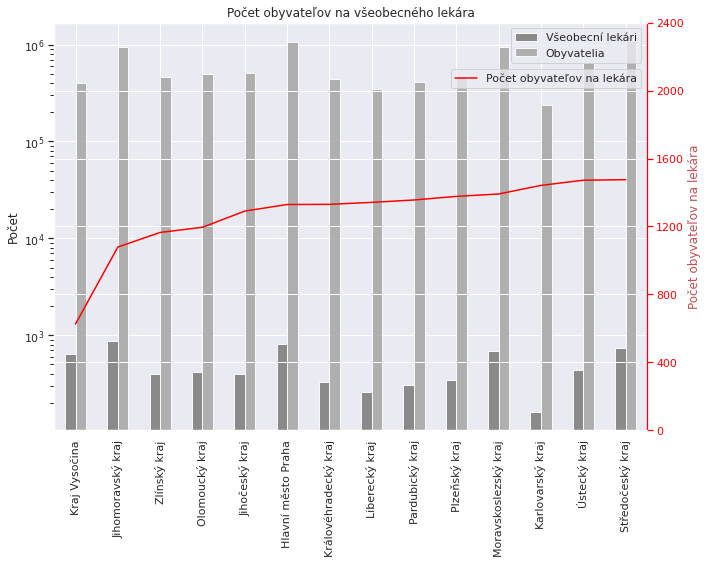

In [145]:
def plot_gp_stats(patients_df, facilities_df):
    summed_patients2 = patients_df[patients_df['casref_do'] > pd.Timestamp(
        2020, 12, 30)].dropna()
    children = ['0 až 5 (více nebo rovno 0 a méně než 5)', '5 až 10 (více nebo rovno 5 a méně než 10)',
                '10 až 15 (více nebo rovno 10 a méně než 15)', '15 až 20 (více nebo rovno 15 a méně než 20)']
    summed_patients2 = summed_patients2[~summed_patients2['vek_txt'].isin(
        children)]
    summed_patients = summed_patients2[summed_patients2['Kraj']
                                       != 'Česká republika'].groupby('Kraj').sum()
    summed_gps2 = facilities_df[facilities_df['Kraj'] != 'Česká republika']
    summed_gps = summed_gps2[summed_gps2['OborPece'] ==
                             'všeobecné praktické lékařství'].groupby('Kraj').count()
    summed_patients['hodnota'] = summed_patients['hodnota'] / 2
    summed_patients.loc[summed_patients.index == 'Hlavní město Praha',
                        'hodnota'] = summed_patients.loc[summed_patients.index == 'Hlavní město Praha', 'hodnota'] * 2
    summed_patients['GpCount'] = summed_gps['ZdravotnickeZarizeniId']
    summed_patients['GpPerPopulation'] = summed_patients['hodnota'] / \
        summed_patients['GpCount']
    summed_patients.sort_values(by=['GpPerPopulation'], inplace=True)
    ax = summed_patients.plot(kind='bar', y=['GpCount', 'hodnota'], color=[
        'gray', 'darkgray'], alpha=0.9, figsize=(10, 8))
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=summed_patients,
                       x=summed_patients.index, y='GpPerPopulation', color='red')
    ax.set_ylabel('Počet')
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.legend(['Všeobecní lekári', 'Obyvatelia'])
    ax2.set_ylabel(ax2.get_ylabel(), color='r')
    ax2.set_yticks([x for x in range(0, 2500, 400)], color='r')
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylabel('Počet obyvateľov na lekára')
    #ax2.legend('Počet obyvateľov na lekára')
    ax2.legend(['Počet obyvateľov na lekára',], bbox_to_anchor=(1, 0.9))
    plt.title('Počet obyvateľov na všeobecného lekára')
    plt.tight_layout()
    plt.xticks(rotation=75)
    plt.savefig('plots/population_per_gp.png')
    


plot_gp_stats(patients_df, facilities_df)


#### Vlatný graf: Mapa zobrazujúca počet poskytovateľov zdravotnej služby v jednej obci.

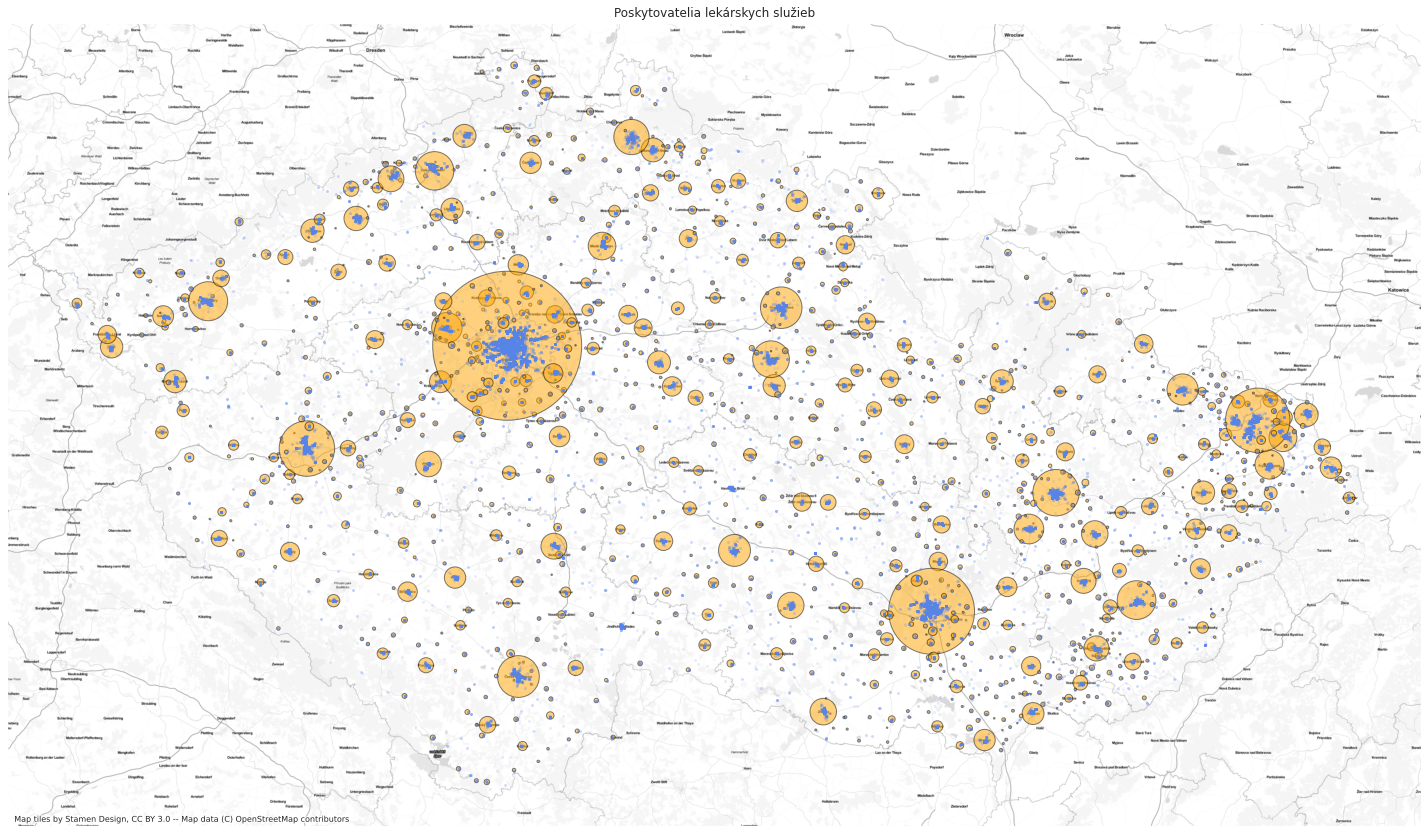

<Figure size 576x432 with 0 Axes>

In [146]:
def prepare_coords_df(facilities_df):
     facilities = facilities_df.copy()
     facilities['Obec'].replace(to_replace=r'Praha.*', regex=True, value='Praha', inplace=True)
     facilities = facilities.groupby('Obec').count()
     facilities = facilities.reset_index()

     #https://simplemaps.com/data/cz-cities
     if not path.isfile('cities.csv'):
          url = 'https://simplemaps.com/static/data/country-cities/cz/cz.csv'
          r = requests.get(url, allow_redirects=True)
          open("cities.csv", 'wb').write(r.content)
          
     cities = pd.read_csv('cities.csv', encoding='utf-8')
     cities['city'].replace({'Prague': "Praha"}, inplace=True)
     cities.set_index('city', inplace=True)
     cities = cities[~cities.index.duplicated(keep='first')]

     lats = []
     lngs = []
     for index, facility in facilities.iterrows():
          try:
               tmp1 = cities.at[facility['Obec'], 'lat']
               tmp2 = cities.at[facility['Obec'], 'lng']
               lats.append(tmp1)
               lngs.append(tmp2)
          except KeyError:
               lats.append(None)
               lngs.append(None)
     facilities['lat'] = pd.Series(lats)
     facilities['lng'] = pd.Series(lngs)
     facilities.dropna()

     return facilities

facilities = prepare_coords_df(facilities_df)

def plot_facilities_map(facilities):
    gdf = gpd.GeoDataFrame(facilities, geometry=gpd.points_from_xy(facilities['lng'], facilities['lat']), crs="EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")
    fig = plt.figure(figsize=(20, 20))
    ax = plt.gca()
    gdf.plot(ax=ax, alpha=0.5, markersize=facilities['PCZ']*2, color='orange', edgecolor='black').set_title("Poskytovatelia lekárskych služieb")
    ax.set_xticks([])
    ax.set_yticks([])

    facilities_df[['lat', 'lng']] = facilities_df['GPS'].str.split(' ', 1, expand=True)
    gdf2 = gpd.GeoDataFrame(facilities_df, geometry=gpd.points_from_xy(facilities_df['lng'], facilities_df['lat']), crs="EPSG:4326")
    gdf2 = gdf2.to_crs("EPSG:3857")
    gdf2.plot(ax=ax, alpha=0.1, markersize=4, color='#5684f0', legend=True)

    ctx.add_basemap(ax=ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite, zoom=10)
    plt.tight_layout()
    plt.show()
    plt.savefig('plots/facility_map.png')

plot_facilities_map(facilities)


### Dotaz C:
#### Připravte trénovací datovou sadu pro klasifikátor, který na základě počtu poskytovatelů vybraných zdravotních služeb a věkového složení obyvatel odhadne velikost města (jako kategorický atribut - malé/střední/velké podle počtu obyvatel). Uvažujte následující kategorie měst: malá - do 8 tis. obyvatel, střední 8 - 30 tis. obyvatel a velká nad 30 tis. obyvatel. Pro potřeby projektu vyberte libovolně 60 měst (20 z každé kategorie), pro která najdete potřebné hodnoty. Atributy: počty poskytovatelů pro následující obory péče: dentální hygienistka/dětské lékařství/fyzioterapeut/chirurgie/kardiologie/Optometrista/ortopedie a traumatologie pohybového ústrojí/praktické lékařství pro děti a dorost/všeobecné praktické lékařství/zubní lékařství, procento obyvatel ve věkových skupinách 0-14 let a 15-64 roků.


In [147]:
df = pd.DataFrame()
df['Obec'] = patients_df[patients_df['vuzemi_txt'] != patients_df['Kraj']]['vuzemi_txt'].unique()
ser = []
for index, obec in df['Obec'].iteritems():
    ser.append(
        patients_df.loc[
            (patients_df['vuzemi_txt'] == obec) & 
            (patients_df['vek_txt'].isna()) & 
            (patients_df['pohlavi_txt'].isna()) & 
            (patients_df['casref_do'] > pd.Timestamp(2020, 12, 30))
        , 'hodnota']
    )

lulser = {}
for i in range(0, 61, 5):
    lmao = []
    for index, obec in df['Obec'].iteritems():
        lmao.append(
            patients_df.loc[
                (patients_df['vuzemi_txt'] == obec) & 
                (patients_df['vek_txt'].str.startswith(str(i))) &
                (patients_df['pohlavi_txt'].isna()) & 
                (patients_df['casref_do'] > pd.Timestamp(2020, 12, 30))
            , 'hodnota']
        )
    lulser[i] = [a.values[0] for a in lmao]


kekser = {}
for i, j in zip([0, 15], [10, 60]):
    kekser[i] = []
    for k in range(len(lulser[i])):
        kekser[i].append(sum([lulser[x][k] for x in range(i, j+1, 5)]))

df['people'] = [a.values[0] for a in ser]
df['0-14'] = kekser[0]
df['15-64'] = kekser[15]
df.sort_values(by='people', inplace=True)

def maps(x):
    if x < 95000:
        return 'small'
    elif x < 120000:
        return 'medium'
    else:
        return 'large'

df['category'] = df['people'].apply(lambda x: maps(x))

facilities = facilities_df.copy()
types = ['všeobecné praktické lékařství', 'Dentální hygienistka', 'dětské lékařství', 'Fyzioterapeut', 'chirurgie', 'kardiologie', 
        'Optometrista', 'ortopedie a traumatologie pohybového ústrojí', 'praktické lékařství pro děti a dorost', 'zubní lékařství']
facilities = facilities[facilities['Okres'] != 'Hlavní město Praha']

final = pd.DataFrame()
for obor in types:
    tmp = facilities[facilities['OborPece'] == obor]
    final[obor] = tmp.groupby('Okres').count()['ZdravotnickeZarizeniId']

df.rename(columns={'Obec': 'Okres'}, inplace=True)
final.reset_index(inplace=True)
final = pd.merge(final, df, on='Okres')

final['0-14'] = final['0-14'] / final['people']
final['15-64'] = final['15-64'] / final['people']

final.to_csv('classificator_data.csv')
final

,Okres,všeobecné praktické lékařství,Dentální hygienistka,dětské lékařství,Fyzioterapeut,chirurgie,kardiologie,Optometrista,ortopedie a traumatologie pohybového ústrojí,praktické lékařství pro děti a dorost,zubní lékařství,people,0-14,15-64,category
0,Benešov,62,13.0,2.0,25,11,6,2,10,30,79,99742,0.172986,0.624040,medium
1,Beroun,53,2.0,5.0,22,17,10,7,12,22,69,96403,0.178272,0.635769,medium
2,Blansko,73,7.0,10.0,20,9,5,9,18,22,54,109104,0.172459,0.626054,medium
3,Brno-město,302,61.0,5.0,193,100,49,57,80,90,334,382405,0.165474,0.634545,large
4,Brno-venkov,132,9.0,NaN,33,13,8,20,13,44,67,226442,0.180227,0.631645,large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Česká Lípa,49,4.0,3.0,21,12,4,3,9,25,51,102998,0.172712,0.642197,medium
72,České Budějovice,111,7.0,24.0,73,28,10,16,19,40,179,196602,0.175512,0.635731,large
73,Český Krumlov,41,2.0,6.0,10,8,2,6,3,35,37,61320,0.176125,0.645841,small
74,Šumperk,76,1.0,5.0,41,13,6,7,16,29,67,119967,0.169505,0.627498,medium


#### Boxplot pre fyzioterapeuta

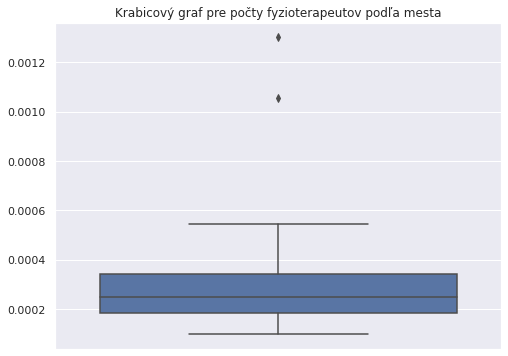

In [148]:
sns.boxplot(data=final, y=final['Fyzioterapeut']/final['people'])
plt.title('Krabicový graf pre počty fyzioterapeutov podľa mesta')
plt.savefig('plots/fyzio_boxplot.png')

#### Normalizácia a diskretizácia dát

In [149]:
final2 = final.fillna(0).copy()
#eliminacia odlahlych hodnot
for type in types:
    podiel = final2[type] / final2['people']
    ds = podiel.describe()
    akoze_max = ds['75%'] + (ds['75%'] - ds['25%']) * 1.5

    mean = podiel.mean()
    final2.loc[final2[type] / final2['people'] > akoze_max, type] = mean*final2['people']
    final2[type] = final2[type].astype(int)

#normalizacia
final2['chirurgie_norm'] = (final2['chirurgie']-final2['chirurgie'].min())/(final2['chirurgie'].max()-final2['chirurgie'].min())

#diskretizacia
final2['kardiologie_disc'] = pd.qcut(final2['kardiologie'], q=4, labels=range(4))
final2.to_csv('classificator_data_edited.csv')
final2


,Okres,všeobecné praktické lékařství,Dentální hygienistka,dětské lékařství,Fyzioterapeut,chirurgie,kardiologie,Optometrista,ortopedie a traumatologie pohybového ústrojí,praktické lékařství pro děti a dorost,zubní lékařství,people,0-14,15-64,category,chirurgie_norm,kardiologie_disc
0,Benešov,62,13,2,25,11,6,2,10,30,79,99742,0.172986,0.624040,medium,0.173913,1
1,Beroun,53,2,5,22,17,10,7,12,22,69,96403,0.178272,0.635769,medium,0.304348,3
2,Blansko,73,7,10,20,9,5,9,18,22,54,109104,0.172459,0.626054,medium,0.130435,1
3,Brno-město,302,20,5,193,49,22,27,80,90,334,382405,0.165474,0.634545,large,1.000000,3
4,Brno-venkov,132,9,0,33,13,8,20,13,44,67,226442,0.180227,0.631645,large,0.217391,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Česká Lípa,49,4,3,21,12,4,3,9,25,51,102998,0.172712,0.642197,medium,0.195652,0
72,České Budějovice,111,7,9,73,28,10,16,19,40,179,196602,0.175512,0.635731,large,0.543478,3
73,Český Krumlov,41,2,6,10,8,2,6,3,15,37,61320,0.176125,0.645841,small,0.108696,0
74,Šumperk,76,1,5,41,13,6,7,16,29,67,119967,0.169505,0.627498,medium,0.217391,1
